In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%aimport decompV
%aimport model_chol
%aimport simulation

In [2]:
import os.path
from datetime import datetime
import numpy as np
from scipy import linalg
from pylab import *
from sklearn.decomposition.factor_analysis import FactorAnalysis

import decompV, model_chol
import simulation

# No spike regression

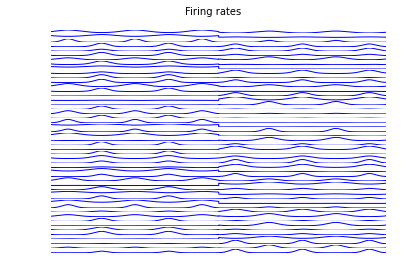

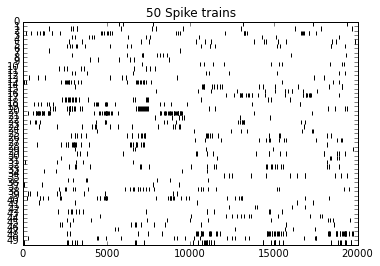

In [8]:
np.random.seed(0)

T = 20000
p = 0
L = 2
N = 50

high = np.log(25 / T)
low = np.log(5 / T)

# simulate latent processes
# x, ticks = simulation.latents(L, T, std, w)
x = np.empty((T, L), dtype=float)
x[:T // 2, 0] = high
x[T // 2:, 0] = low
x[:, 1] = 2 * np.sin(np.linspace(0, 2 * np.pi * 5, T))
for l in range(L):
    x[:, l] -= np.mean(x[:, l])

# simulate spike trains
a = 2 * np.random.rand(L, N) - 1
for l in range(L):
    a[l, :] /= linalg.norm(a[l, :]) / np.sqrt(N)

b = np.empty((1 + p*N, N))
b[0, :] = low

y, _, rate = simulation.spikes(x, a, b, intercept=True)
figure()
_, ax = subplots(N, sharex=True)
for n in range(N):
    ax[n].plot(rate[:, n])
    ax[n].axis('off')
suptitle('Firing rates')

figure()
ylim(0, N)
for n in range(N):
    vlines(np.arange(T)[y[:, n] > 0], n, n + 1, color='black')
title('{} Spike trains'.format(N))
yticks(range(N))
gca().invert_yaxis()

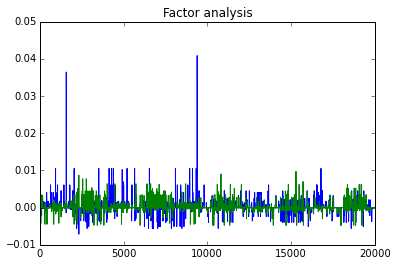

In [9]:
fa = FactorAnalysis(n_components=L)
m0 = fa.fit_transform(y)
a0 = fa.components_
# a0 = np.random.randn(L, N)
m0 *= np.linalg.norm(a0) / np.sqrt(N)
a0 /= np.linalg.norm(a0) / np.sqrt(N)

mu = np.zeros_like(x)

figure()
plot(m0)
title('Factor analysis')

In [10]:
var = np.empty(L, dtype=float)
var[0] = 5
var[1] = 5
w = np.empty(L, dtype=float)
w[0] = 1e-6
w[1] = 1e-4

control = {'max iteration': 50,
           'fixed-point iteration': 10,
           'tol': 1e-5,
           'verbose': True}

lbound, m1, a1, b1, new_var, new_scale, a0, b0, elapsed, converged = decompV.train(y, 0, var, w, b0=None, m0=m0, anorm=np.sqrt(N), 
                                                                           hyper=False, kchol=100, niter=50, tol=1e-5, verbose=True)


Iteration[1]
lower bound = -8019079.43844
increment = 153778719701.7834167480
time = 35.26s
change in alpha = 0.0000000000
change in beta = 0.9999999999
change in posterior mean = 0.0000000000
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[2]
lower bound = -2012236.36660
increment = 6006843.0718348240
time = 36.29s
change in alpha = 0.0000000000
change in beta = 1.4995923074
change in posterior mean = 0.0200077249
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[3]
lower bound = -509928.71222
increment = 1502307.6543816496
time = 35.52s
change in alpha = 0.0000000000
change in beta = 2.2472603909
change in posterior mean = 0.0100680664
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[4]
lower bound = -146075.62889
increment = 363853.0833359460
time = 35.78s
change in alpha = 0.0000000000
change in beta = 2.2240792687
change in posterior mean = 0.0425387606
change in p

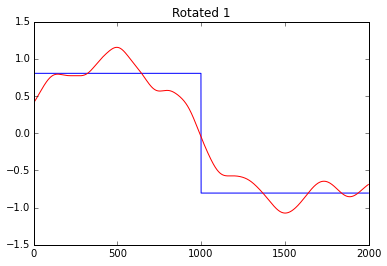

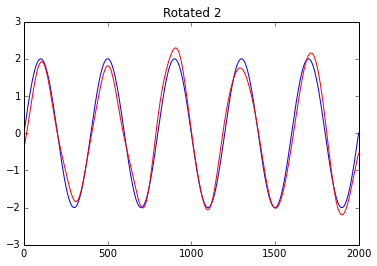

In [6]:
c = linalg.lstsq(m1, x)[0]
rotated = np.dot(m1, c)
for l in range(L):
    figure()
    plot(x[:, l] - np.mean(x[:, l]), label='latent', color='blue')
    plot(rotated[:, l], label='transformed posterior', color='red')
    title('Rotated {}'.format(l + 1))

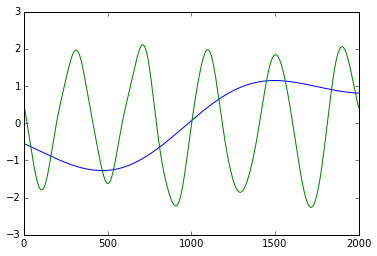

In [7]:
plot(m1)